**Section 1 勾配消失問題**

In [20]:
cd C:\Users\zawaz\Desktop\study_ai_ml_google\DNN_code_colab_lesson_1_2

C:\Users\zawaz\Desktop\study_ai_ml_google\DNN_code_colab_lesson_1_2


In [2]:
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt


class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成, sigmoidとreluのみ扱う
        activation_layer = {'sigmoid': layers.Sigmoid, 'relu': layers.Relu}
        self.layers = OrderedDict() # 追加した順番に格納
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = layers.SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, d):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        for idx in range(1, self.hidden_layer_num+2):
            grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grad

データ読み込み完了
Generation: 100. 正答率(トレーニング) = 0.12
                : 100. 正答率(テスト) = 0.207
Generation: 200. 正答率(トレーニング) = 0.19
                : 200. 正答率(テスト) = 0.2513
Generation: 300. 正答率(トレーニング) = 0.67
                : 300. 正答率(テスト) = 0.56
Generation: 400. 正答率(トレーニング) = 0.71
                : 400. 正答率(テスト) = 0.7388
Generation: 500. 正答率(トレーニング) = 0.9
                : 500. 正答率(テスト) = 0.8384
Generation: 600. 正答率(トレーニング) = 0.88
                : 600. 正答率(テスト) = 0.8599
Generation: 700. 正答率(トレーニング) = 0.91
                : 700. 正答率(テスト) = 0.8895
Generation: 800. 正答率(トレーニング) = 0.94
                : 800. 正答率(テスト) = 0.9067
Generation: 900. 正答率(トレーニング) = 0.95
                : 900. 正答率(テスト) = 0.918
Generation: 1000. 正答率(トレーニング) = 0.97
                : 1000. 正答率(テスト) = 0.9216
Generation: 1100. 正答率(トレーニング) = 0.9
                : 1100. 正答率(テスト) = 0.924
Generation: 1200. 正答率(トレーニング) = 0.96
                : 1200. 正答率(テスト) = 0.9336
Generation: 1300. 正答率(トレーニング) = 0.97
                : 1300. 正答率(テス

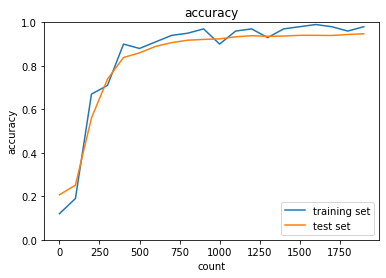

In [19]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 30, 30, 20],
                        output_size=10, activation='relu', weight_init_std=0.1)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=100

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in network.params.keys():
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

In [14]:
network.params.keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])

活性化関数の定義と、重みの初期化方法を変えると、学習にどのような変化が起こるのかを確認した。  
活性化関数の違いは、中間層の数が少ないうちはそれほど大きな影響は見られなかったが、層が厚くなるにつれて、reluの方が正しく学習が行われた。  
一方で、重みの初期化方法は少ない層でも影響があった。xavierとheの違いはなかなかつかめなかったが、ガウス分布（0.01）で散らした時は全体的に学習がうまくいかない傾向にあった。一方で分散の大きさを大きくすると学習が進む場合があり、これは、重みの初期値が小さすぎると学習ができなくなることを裏付けている。